In [2]:
%pip install pytrends

Now I will move the `nltk.download` commands to the cell with imports and install `pytrends`.

In [3]:
# Load libraries
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import plotly.graph_objects as go
import re
import time

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pytrends.request import TrendReq
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Download 'punkt' resource
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

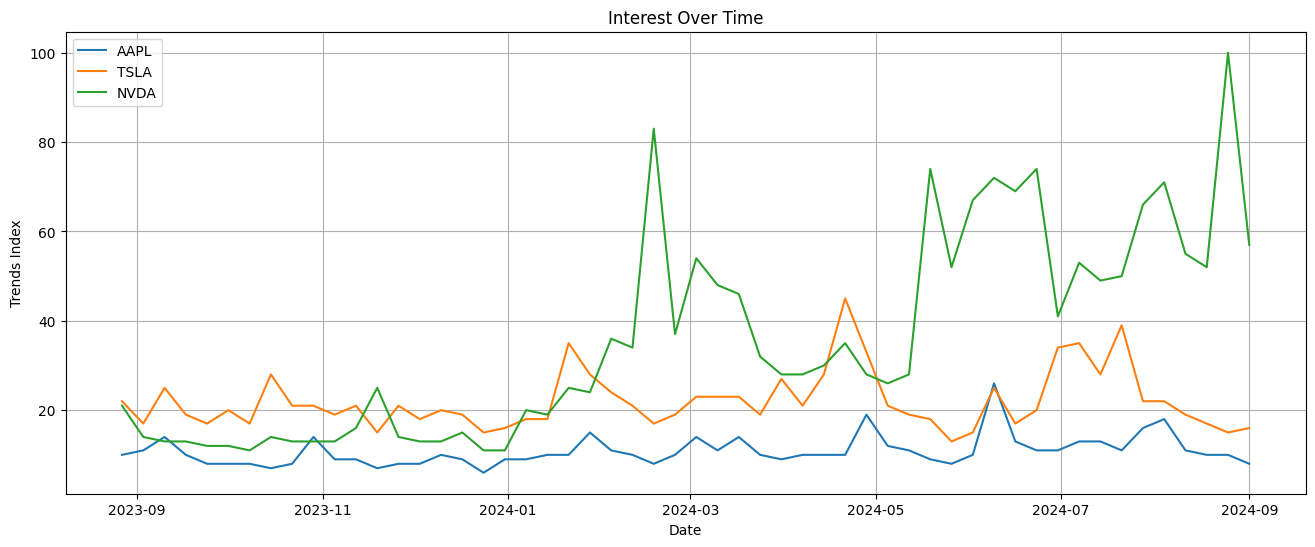

In [4]:
# Initialize an instance of the TrendReq class with US region and 360 timezone
pytrends = TrendReq(hl='en-US', tz=360)

# Define the list of keywords and timeframe
kw_list = ["AAPL", "TSLA", "NVDA"]
timeframe = '2023-09-01 2024-09-01' # for latest 12 months replace with 'today 12-m'

# Build the payload and get the interest over time data
pytrends.build_payload(kw_list, timeframe=timeframe)
interest_over_time_df = pytrends.interest_over_time()

# Create a figure and axes and plot the data
plt.figure(figsize=(16, 6))
for term in kw_list:
  plt.plot(interest_over_time_df.index, interest_over_time_df[term], label=term)

plt.xlabel('Date')
plt.ylabel('Trends Index')
plt.title('Interest Over Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [5]:
# Initialize an instance of the TrendReq class and build the payload
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(["NVDA"], timeframe='2023-09-01 2024-09-01')

# Get the interest by region data
interest_by_region_df = pytrends.interest_by_region()
interest_by_region_df.sort_values(by='NVDA', ascending=False).head(10)

,NVDA
geoName,
Hong Kong,100
Taiwan,85
Israel,80
United States,65
Singapore,61
Canada,57
China,33
Switzerland,16
South Korea,13


In [7]:
# Read the CSV file
df = pd.read_csv('NVDA-relatedQueries.csv', header=None, delimiter='\t')

# Find the start and end rows for each section
top_start = df[df.iloc[:, 0] == 'TOP'].index[0] + 1
top_end = df[df.iloc[:, 0] == 'RISING'].index[0] - 1
rising_start = df[df.iloc[:, 0] == 'RISING'].index[0] + 1
rising_end = df.shape[0]  # End of the DataFrame
# Extract top queries
queries_top = df.iloc[top_start:top_end].copy()
queries_top = queries_top.rename(columns={queries_top.columns[0]: 'top_queries'})

# Split the 'top_queries' column and convert 'value' to numeric
queries_top[['top_query', 'value']] = queries_top['top_queries'].str.split(',', expand=True)
queries_top = queries_top[['top_query', 'value']]
queries_top.loc[:, 'value'] = pd.to_numeric(queries_top['value'])
queries_top
# Extract rising queries
queries_rising = df.iloc[rising_start:rising_end].copy()
queries_rising = queries_rising.rename(columns={queries_rising.columns[0]: 'rising_queries'})

# Split the 'rising_queries' column aon the first comma
queries_rising[['rising_query', 'value']] = queries_rising['rising_queries'].str.split(',', n=1, expand=True)
queries_rising = queries_rising[['rising_query', 'value']]

# Clean the 'value' column
queries_rising['value'] = queries_rising['value'].str.replace(r'[^0-9.-]', '', regex=True)  # Keep only numbers, dots, and minus signs
queries_rising.loc[:, 'value'] = pd.to_numeric(queries_rising['value'], errors='coerce')  # Convert to numeric

# Display 'rising_queries'
queries_rising

,rising_query,value
28,Rivian,3100
29,NASDAQ:FFAI,2400
30,NASDAQ:DJT,900
31,NASDAQ:ASTS,650
32,NYSE:GME,500
33,Tesla,300
34,GameStop,300
35,GameStop,300
36,Stock market prediction,250
37,NYSE:CMG,200


In [8]:
# Sample documents
documents = [
    "Risk management in derivatives trading",
    "Portfolio optimization techniques and strategies",
    "Algorithmic trading and its impact on market efficiency",
    "Quantitative methods for financial modeling",
    "High-frequency trading and liquidity provision",
    "Integrating Derivatives into Portfolio Optimization Strategies",
    "High-Frequency Trading Strategies: Algorithmic Approaches and Market Impact",
    "Quantitative Methods for Algorithmic Trading and Portfolio Optimization"
]

# Download stopwords and WordNet resources and then create a Lemmatizer Object
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

# construct text preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^\w\s-]', '', text)  # Remove punctuation except hyphens
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # Lemmatize
    stop_words = set(stopwords.words('english')) # define stop_words as a set of english stop words
    tokens = [token for token in tokens if token not in stop_words] # Remove stop words
    return tokens

# Create a CountVectorizer object
vectorizer = CountVectorizer(tokenizer=preprocess_text, token_pattern=None)

# Create the term-document matrix, then convert to a pandas DataFrame
term_document_matrix = vectorizer.fit_transform(documents)
df = pd.DataFrame(term_document_matrix.toarray(), columns = vectorizer.get_feature_names_out())
term_document_matrix = df.T
print(term_document_matrix)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                0  1  2  3  4  5  6  7
algorithmic     0  0  1  0  0  0  1  1
approach        0  0  0  0  0  0  1  0
derivative      1  0  0  0  0  1  0  0
efficiency      0  0  1  0  0  0  0  0
financial       0  0  0  1  0  0  0  0
high-frequency  0  0  0  0  1  0  1  0
impact          0  0  1  0  0  0  1  0
integrating     0  0  0  0  0  1  0  0
liquidity       0  0  0  0  1  0  0  0
management      1  0  0  0  0  0  0  0
market          0  0  1  0  0  0  1  0
method          0  0  0  1  0  0  0  1
modeling        0  0  0  1  0  0  0  0
optimization    0  1  0  0  0  1  0  1
portfolio       0  1  0  0  0  1  0  1
provision       0  0  0  0  1  0  0  0
quantitative    0  0  0  1  0  0  0  1
risk            1  0  0  0  0  0  0  0
strategy        0  1  0  0  0  1  1  0
technique       0  1  0  0  0  0  0  0
trading         1  0  1  0  1  0  1  1


In [9]:
# Get the terms (words) from the term-document matrix
terms = term_document_matrix.index

# Create an LSA model and fit to term_document_matrix
lsa = TruncatedSVD(n_components=2, random_state=42)
lsa_matrix = lsa.fit_transform(term_document_matrix)

# Create DataFrame for LSA results with term names and print it
df_lsa = pd.DataFrame(lsa_matrix, index=terms)
print(df_lsa)

                       0         1
algorithmic     1.487743 -0.457823
approach        0.578476 -0.378199
derivative      0.492907  0.525547
efficiency      0.427052 -0.387020
financial       0.099332  0.155108
high-frequency  0.812589 -0.596790
impact          1.005528 -0.765219
integrating     0.286096  0.555942
liquidity       0.234112 -0.218591
management      0.206810 -0.030394
market          1.005528 -0.765219
method          0.581547  0.462505
modeling        0.099332  0.155108
optimization    1.015624  1.343809
portfolio       1.015624  1.343809
provision       0.234112 -0.218591
quantitative    0.581547  0.462505
risk            0.206810 -0.030394
strategy        1.111885  0.658213
technique       0.247313  0.480471
trading         1.928666 -0.706808


In [10]:
# Create a list of hover texts with labels and coordinates
hover_texts = []
for row in df_lsa.values:
    terms = df_lsa.index[(df_lsa[0] == row[0]) & (df_lsa[1] == row[1])]
    terms_str = ', '.join([f'"{term}"' for term in terms])
    coord = f"({row[0]:.5f}, {row[1]:.5f})"
    hover_texts.append(f"Terms: {terms_str}<br>{coord}")

# Create the scatter plot
fig = go.Figure(go.Scatter(
    x=df_lsa[0],
    y=df_lsa[1],
    mode='markers',
    marker=go.scatter.Marker(
        size=10,
        color='blue',
        opacity=0.8
    ),
    hovertemplate='%{text}<extra></extra>',
    text=hover_texts
))

# Set axis labels and title
fig.update_layout(
    xaxis_title="Component 0",
    yaxis_title="Component 1",
    title="LSA Results Scatter Plot"
)

fig.show()

In [11]:
# Extract term vectors for first distinct cluster
terms_cl1 = ["algorithmic", "high-frequency", "impact", "market", "trading"]
term_vectors_cl1 = df_lsa.loc[terms_cl1]

# Calculate cosine similarity
similarity_matrix = cosine_similarity(term_vectors_cl1)

# Convert to DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=terms_cl1, columns=terms_cl1)

# Print the results for the first distinct cluster with labels
print("Cosine similarity for first distinct cluster:")
print(similarity_df)

Cosine similarity for first distinct cluster:
                algorithmic  high-frequency    impact    market   trading
algorithmic        1.000000        0.944434  0.938692  0.938692  0.998609
high-frequency     0.944434        1.000000  0.999855  0.999855  0.960449
impact             0.938692        0.999855  1.000000  1.000000  0.955562
market             0.938692        0.999855  1.000000  1.000000  0.955562
trading            0.998609        0.960449  0.955562  0.955562  1.000000


In [14]:
# Extract term vectors for fourth cluster
terms_cl4 = ["management", "risk", "liquidity", "provision"]
term_vectors_cl4 = df_lsa.loc[terms_cl4]

# Calculate cosine similarity
similarity_matrix = cosine_similarity(term_vectors_cl4)

# Convert to DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=terms_cl4, columns=terms_cl4)

# Print the results for the fourth cluster with labels
print("Cosine similarity for fourth cluster:")
print(similarity_df)

Cosine similarity for fourth cluster:
            management      risk  liquidity  provision
management    1.000000  1.000000   0.822387   0.822387
risk          1.000000  1.000000   0.822387   0.822387
liquidity     0.822387  0.822387   1.000000   1.000000
provision     0.822387  0.822387   1.000000   1.000000


In [15]:
# Extract term vectors for distinct pair
terms_pair = ["financial", "modeling"]
term_vectors_pair = df_lsa.loc[terms_pair]

# Extract term vectors for second and third cluster
term_vectors_cl2 = df_lsa.loc[["optimization", "portfolio"]]
term_vectors_cl3 = df_lsa.loc[["derivative", "method", "quantitative"]]


# Calculate centroid for the distinct pair
centroid_pair = term_vectors_pair.mean()

# Store cluster term vectors in a list and calculate centroids for each cluster
cluster_term_vectors = [term_vectors_cl1, term_vectors_cl2, term_vectors_cl3, term_vectors_cl4]
centroids = [term_vectors.mean() for term_vectors in cluster_term_vectors]


# Calculate cosine similarity between the distinct pair and each cluster centroid
similarities = [cosine_similarity(centroid_pair.values.reshape(1, -1), centroid.values.reshape(1, -1)) for centroid in centroids]

# Print the similarities
for i, similarity in enumerate(similarities):
  print(f"Cosine similarity between distinct pair and cluster {i+1}:", similarity)

Cosine similarity between distinct pair and cluster 1: [[0.08406783]]
Cosine similarity between distinct pair and cluster 2: [[0.9969915]]
Cosine similarity between distinct pair and cluster 3: [[0.96054718]]
Cosine similarity between distinct pair and cluster 4: [[0.05551994]]


In [16]:
# Create a TfidfVectorizer object and fit to to documents
tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess_text, token_pattern=None)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# alculate the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix)

# Present TF-IDF matrix in DataFrame form
short_labels = ['Doc ' + str(i+1) for i in range(len(documents))]
df = pd.DataFrame(cosine_sim, index=short_labels, columns=short_labels)
df

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8
Doc 1,1.000000,0.000000,0.100709,0.000000,0.104403,0.223556,0.085795,0.100002
Doc 2,0.000000,1.000000,0.000000,0.000000,0.000000,0.541226,0.154369,0.359862
Doc 3,0.100709,0.000000,1.000000,0.000000,0.100709,0.000000,0.589201,0.256616
Doc 4,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.419796
Doc 5,0.104403,0.000000,0.100709,0.000000,1.000000,0.000000,0.277083,0.100002
Doc 6,0.223556,0.541226,0.000000,0.000000,0.000000,1.000000,0.136797,0.318899
Doc 7,0.085795,0.154369,0.589201,0.000000,0.277083,0.136797,1.000000,0.218614
Doc 8,0.100002,0.359862,0.256616,0.419796,0.100002,0.318899,0.218614,1.000000


In [17]:
# Sample documents
documents = [
    "Risk management in derivatives trading",
    "Portfolio optimization techniques and strategies",
    "Algorithmic trading and its impact on market efficiency",
    "Quantitative methods for financial modeling",
    "High-frequency trading and liquidity provision",
    "Integrating Derivatives into Portfolio Optimization Strategies",
    "High-Frequency Trading Strategies: Algorithmic Approaches and Market Impact",
    "Quantitative Methods for Algorithmic Trading and Portfolio Optimization"
]

# Download stopwords, WordNet resources and create a Lemmatizer Object
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^\w\s-]', '', text)  # Remove punctuation except hyphens
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # Lemmatize
    stop_words = set(stopwords.words('english')) # define stop_words as a set of english stop words
    tokens = [token for token in tokens if token not in stop_words] # Remove stop words
    return tokens


# Function to calculate Jaccard similarity between two documents
def jaccard_similarity(doc1, doc2):
    # Preprocess documents
    tokens1 = set(preprocess_text(doc1))
    tokens2 = set(preprocess_text(doc2))

    # Calculate Jaccard similarity
    intersection = len(tokens1.intersection(tokens2))
    union = len(tokens1.union(tokens2))
    return intersection / union

# Calculate Jaccard similarity matrix
jaccard_sim = [[jaccard_similarity(doc1, doc2) for doc2 in documents] for doc1 in documents]

# Present Jaccard similarity matrix in DataFrame form
short_labels = ['Doc ' + str(i+1) for i in range(len(documents))]
df = pd.DataFrame(jaccard_sim, index=short_labels, columns=short_labels)
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8
Doc 1,1.000000,0.00,0.125000,0.00,0.142857,0.125000,0.100000,0.111111
Doc 2,0.000000,1.00,0.000000,0.00,0.000000,0.500000,0.100000,0.250000
Doc 3,0.125000,0.00,1.000000,0.00,0.125000,0.000000,0.500000,0.222222
Doc 4,0.000000,0.00,0.000000,1.00,0.000000,0.000000,0.000000,0.250000
Doc 5,0.142857,0.00,0.125000,0.00,1.000000,0.000000,0.222222,0.111111
Doc 6,0.125000,0.50,0.000000,0.00,0.000000,1.000000,0.090909,0.222222
Doc 7,0.100000,0.10,0.500000,0.00,0.222222,0.090909,1.000000,0.181818
Doc 8,0.111111,0.25,0.222222,0.25,0.111111,0.222222,0.181818,1.000000
